# Jeff's Migration Data Analysis

In [18]:
import pandas as pd
import plotly.express as px
import json
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from sqlalchemy import create_engine


### READ DATA

In [19]:
migration_df = pd.read_csv('Data/IRS_county_to_county_migration_2017-2021.csv')

counties_df = pd.read_csv('Data/us_counties')
counties_df['fips'] = counties_df['fips'].str[1:-1]

In [20]:
counties_df.head(1)

,county,state,fips_state,fips_county,fips
0,Abbeville,SC,45,1,45001


In [21]:
migration_df.head(1)

,year,dest_state_id,dest_county_id,orig_state_id,orig_county_id,dest_state,dest_county,orig_state,orig_county,inflow_type,returns,individuals,adj_gross_income
0,2017,1,1,96,0,AL,Autauga County Total Migration-US and Foreign,NaN,NaN,us_and_foreign,2400,5702,125069000


In [35]:
migration_df['inflow_type'].unique()

array(['us_and_foreign', 'us', 'same_state', 'different_state', 'foreign',
       'non-migrants', 'us_counties', 'other_same_state',
       'other_diff_state', 'other_foreign'], dtype=object)

In [22]:
movers_df = migration_df[migration_df['inflow_type'] == 'us_counties'].reset_index(drop=True)
non_movers_df = migration_df[migration_df['inflow_type'] == 'non-migrants'].reset_index(drop=True)

# VIEW_DF for map plot

In [23]:
stayputs_df = non_movers_df\
    .groupby(['year', 'dest_state_id', 'dest_county_id'])['individuals']\
    .sum()\
    .reset_index()\
    .rename(columns={'individuals': 'stayput'})

inflows_df = movers_df\
    .groupby(['year', 'dest_state_id', 'dest_county_id'])['individuals']\
    .sum()\
    .reset_index()\
    .rename(columns={'individuals': 'inflow'})

outflows_df = movers_df\
    .groupby(['year', 'orig_state_id', 'orig_county_id'])['individuals']\
    .sum()\
    .reset_index()\
    .rename(columns={'individuals': 'outflow'})

view_df = pd.merge(counties_df, stayputs_df, how='inner', left_on=['fips_state', 'fips_county'], right_on=['dest_state_id', 'dest_county_id']).drop(columns=['dest_state_id', 'dest_county_id'])
view_df = view_df.merge(inflows_df[['dest_state_id', 'dest_county_id', 'year', 'inflow']], how='left', left_on=['fips_state', 'fips_county', 'year'], right_on=['dest_state_id', 'dest_county_id', 'year']).drop(columns=['dest_state_id', 'dest_county_id'])
view_df = view_df.merge(outflows_df[['orig_state_id', 'orig_county_id', 'year', 'outflow']], how='left', left_on=['fips_state', 'fips_county', 'year'], right_on=['orig_state_id', 'orig_county_id', 'year']).drop(columns=['orig_state_id', 'orig_county_id'])


In [24]:
view_df.isna().sum()

county            0
state             0
fips_state        0
fips_county       0
fips              0
year              0
stayput           0
inflow         1651
outflow        1476
dtype: int64

In [25]:
view_df[['inflow', 'outflow']] = view_df[['inflow', 'outflow']].fillna(0)
view_df[['inflow', 'outflow']] = view_df[['inflow', 'outflow']].astype(int)

In [26]:
# create new 'net_migration' column
view_df['net_migration'] = view_df['inflow'] - view_df['outflow']

In [27]:
view_df

,county,state,fips_state,fips_county,fips,year,stayput,inflow,outflow,net_migration
0,Abbeville,SC,45,1,45001,2017,16703,747,852,-105
1,Abbeville,SC,45,1,45001,2018,16829,813,679,134
2,Abbeville,SC,45,1,45001,2019,16862,581,678,-97
3,Abbeville,SC,45,1,45001,2020,16987,669,633,36
4,Abbeville,SC,45,1,45001,2021,16338,573,738,-165
...,...,...,...,...,...,...,...,...,...,...
15645,Ziebach,SD,46,137,46137,2017,945,0,0,0
15646,Ziebach,SD,46,137,46137,2018,942,0,0,0
15647,Ziebach,SD,46,137,46137,2019,938,0,0,0
15648,Ziebach,SD,46,137,46137,2020,995,0,0,0


In [28]:
view_df['net_migration'].max(), view_df['net_migration'].min()

(140792, -121872)

## Create chlorapleth map

#### Shapefile

In [29]:
# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file('/Users/jnorth/Documents/GitHub/Project-3-Covid/Data/SHAPEFILE_US_Census')

In [30]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER',
       'geometry'],
      dtype='object')

In [31]:
merged_gdf = gdf.merge(view_df, left_on='GEOID', right_on='fips', how='left')

In [32]:
geojson_data = merged_gdf.to_json()

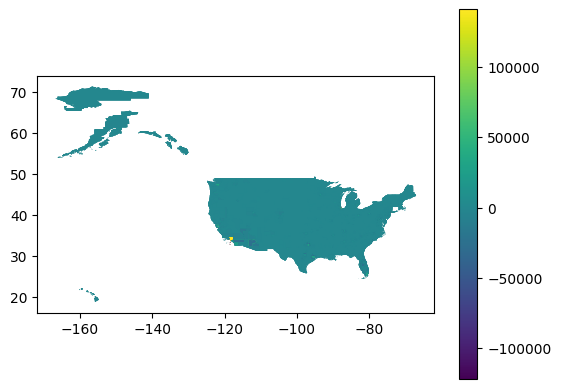

In [33]:
import matplotlib.pyplot as plt

gpd_df = gpd.GeoDataFrame(merged_gdf)
gpd_df.plot(column='net_migration', legend=True)
plt.show()


In [34]:
num_colors = 10  # or any other number of colors you want
colors = plt.cm.plasma(np.linspace(0, 1, num_colors))
color_scale = [mcolors.rgb2hex(color) for color in colors]

geojson_data = merged_gdf.to_json()

# Create a base map
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4) 

bins = [-130000, -4000, -3000, -2500, -500, 0, 500, 1000, 2000, 41000]

# Add the choropleth layer
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=merged_gdf,
    columns=['GEOID', 'net_migration'],
    key_on='feature.properties.GEOID',
    fill_color='viridis',
    bins=bins,
    fill_opacity=.7,
    line_opacity=0.2,
    legend_name='Net Migration'
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Display the map
m

ValueError: All values are expected to fall into one of the provided bins (or to be Nan). Please check the `bins` parameter and/or your data.